#### In the center-of-mass frame
$$\varepsilon_1 = \dfrac{m_0^2 + m_1^2 - m_2^2}{2 m_0}$$
$$p_1 = \sqrt{\varepsilon_1^2 - m_1^2}$$
$$\textbf{p}_2 = -\textbf{p}_1$$
$$\varepsilon_2 = \sqrt{p_2^2 + m_2^2}$$

In [1]:
void two_body_decay(double & m0, double & m1,double & m2, double pcm[][2])
{
    double twoPi = 6.28318530717958648e0;
    double e1,p1;
    double r;
    double SinTh, CosTh;
    double phi;

    e1 = (m0 * m0 + m1 * m1 -  m2 * m2)/(2. * m0);
    p1 = sqrt(fabs((e1 * e1 - m1 * m1)));

    r = gRandom->Rndm(m0);

    CosTh = 2.*r-1.;
    if (fabs(CosTh) >= 1.)
    {
        CosTh = 1.;
        SinTh = 0.;
    }
    else
    {
        SinTh = sqrt((1.-CosTh)*(1.+CosTh));
    }

    r = gRandom->Rndm(m0);
    phi = twoPi * r;

    pcm[0][0] = p1*SinTh*cos(phi);
    pcm[1][0] = p1*SinTh*sin(phi);
    pcm[2][0] = p1*CosTh;
    pcm[3][0] = e1;


    pcm[0][1] = -pcm[0][0];
    pcm[1][1] = -pcm[1][0];
    pcm[2][1] = -pcm[2][0];
    pcm[3][1] = sqrt(pcm[0][1]*pcm[0][1] + pcm[1][1]*pcm[1][1] + pcm[2][1]*pcm[2][1] + m2*m2);
}


#### Loretz transformation:
$$\textbf{p}' = \textbf{p} + \gamma \boldsymbol{\beta} (\dfrac{\gamma (\beta \cdot p)}{\gamma + 1} - \varepsilon)$$
$$\varepsilon ' = \gamma (\varepsilon - (\beta \cdot p))$$

In [2]:
void gloren(double beta[], double pa[], double pb[])
{
   double betpa, bpgam;

   betpa = beta[0]*pa[0]+beta[1]*pa[1]+beta[2]*pa[2];
   bpgam = (betpa*beta[3]/(beta[3]+1.)-pa[3])*beta[3];

   pb[0] = pa[0] + bpgam  * beta[0];   
   pb[1] = pa[1] + bpgam  * beta[1];   
   pb[2] = pa[2] + bpgam  * beta[2];   
   pb[3] =(pa[3] - betpa) * beta[3];   
}

In [3]:
void my_loren(double beta[], double pa[], double pb[])
{
   double betpa, bpgam;

   betpa = beta[0]*pa[0]+beta[1]*pa[1]+beta[2]*pa[2];
   pb[3] = beta[3]*(pa[3]-betpa);

   bpgam = (pa[3]+pb[3])/(1.+beta[3])*beta[3];
      
   pb[0] = pa[0] - bpgam  * beta[0];   
   pb[1] = pa[1] - bpgam  * beta[1];   
   pb[2] = pa[2] - bpgam  * beta[2];   
}

In [4]:
double sign(double &A, double &B)
{
   double u;
   u = 0;
   if (B >= 0) u =  fabs(A);
   if (B <  0) u = -fabs(A);
   return u;
}

In [5]:
void angles(double p[],double &costh,double &sinth,double &cosph,double &sinph)
{
   double dux,duy,duz,dsith2,one,dnorm;
   double dsith;
   double dmod;

   one =1.;
   dmod = sqrt(p[0]*p[0] + p[1]*p[1] + p[2]*p[2]);
   dux  = p[0]/dmod;
   duy  = p[1]/dmod;
   duz  = p[2]/dmod;

   if (fabs(duz) >= 0.85 )
   {
      dsith2 = dux*dux + duy*duy;
      if (dsith2 >= 0.)
      {
         double s;
         s = sign(one,duz);
         costh = s*sqrt(one - dsith2);
         dsith = sqrt(dsith2);
         sinth = dsith;
         cosph = dux/dsith;
         sinph = duy/dsith;
         cosph = 0.;
         sinph = 0.;
      }
      if (dsith2 <= 0.)
      {
         if (duz > 0.)
         {
            costh = 1.; 
            sinth = 0;
            cosph = 1.; 
            sinph = 0;
         }
         else 
         {
           costh = -1.; 
           sinth =  0;
           cosph =  1.; 
           sinph =  0;
         }
      }
      else
      {
         costh = duz;
         dsith = sqrt(one+duz)*(one-duz);
         sinth = dsith;
         cosph = dux/dnorm;
         sinph = duy/dnorm;
      }
   }
}

In [6]:
void rotate(double p[],double &costh,double &sinth,double &cosph,double &sinph)
{
   double p1,p2,p3;

   p1 = p[0];
   p2 = p[1];
   p3 = p[2];

   p[0]=p1*costh*cosph - p2*sinph + p3*sinth*cosph;
   p[1]=p1*costh*sinph + p2*cosph + p3*sinth*sinph;
   p[2]=p1*sinth                  + p3*costh;
}

In [9]:
void script()
{
    enum EColor { kWhite, kBlack, kRed, kGreen, kBlue, kYellow, kMagenta, kCyan };
    gStyle->SetOptStat(0);
    gStyle->SetOptTitle(1);
    TCanvas*  canvas = new TCanvas("canvas", "armenteros", 600, 500);  
    TH2D* hist_k = new TH2D("hist_k","hist_k", 100,-1.,1.,60,0.,0.3);
    TH2D* hist_l = new TH2D("hist_l","hist_l", 100,-1.,1.,60,0.,0.3);
    TH2D* hist_a = new TH2D("hist_a","hist_a", 100,-1.,1.,60,0.,0.3);
    TH1D* hist_ek = new TH1D("hist_ek","hist_ek", 100, 0, 100);
    TH1D* hist_el = new TH1D("hist_el","hist_el", 100, 0, 100);
    
    TH1D* hist_ppi = new TH1D("hist_pi","hist_pi", 100, 0, 20);
    TH1D* hist_pp = new TH1D("hist_pp","hist_pp", 100, 0, 20);


    hist_k->SetTitle("(p_{t} - #alpha) histogram (1); #alpha; P_{t} [GeV/c]");
    hist_ek->SetTitle("(2); p_{#pi}; Counts");
    hist_ppi->SetTitle("(3); p and #pi^{-} momenta in #Lambda decay; Counts");

    hist_k->SetTitleFont(62);
    hist_ek->SetTitleFont(62);
    hist_ppi->SetTitleFont(62);
    
    int n = 4000;
    
    // K-short meson params
    double mk0, mk1, mk2;
    mk0 = 0.49767; 
    mk1 = 0.1396;
    mk2 = 0.1396;
    
    double pcm[4][2];

    double pa[4], plab[4], beta[4];

    double e0;

    double p0 = 50.;
    e0 = sqrt(p0*p0 + mk0*mk0);

    beta[0] = 0.;
    beta[1] = 0.;
    beta[2] = -p0 / e0;
    beta[3] = e0 / mk0;

    two_body_decay(mk0, mk1, mk2, pcm);

    double pcms1[4],pcms2[4];
    double pk0_pi1[4],pk0_pi2[4];
    double pl0_pi1[4],pl0_pi2[4];
    double pa0_pi1[4],pa0_pi2[4];

    for (int i=0; i < 4; ++i)
    {
       pcms1[i] = pcm[i][0];
       pcms2[i] = pcm[i][1];
    }

    gloren(beta, pcms1, pk0_pi1);
    gloren(beta, pcms2, pk0_pi2);

    double costh,sinth,cosph,sinph;
    double alpha[4000];
    double PL1[4000], PL2[4000], PT1[4000], PT2[4000];
 
    double pk0[5], pl0[5], pa0[5];

    for(auto i = 0; i < n; ++i)
    {
        two_body_decay( mk0, mk1, mk2, pcm);

        for (int k=0;k<4;++k)
        {
            pcms1[k] = pcm[k][0];
            pcms2[k] = pcm[k][1];
        }

        my_loren(beta, pcms1, pk0_pi1);
        my_loren(beta, pcms2, pk0_pi2);

        pk0[0] =  pk0_pi1[0]+ pk0_pi2[0]; 
        pk0[1] =  pk0_pi1[1]+ pk0_pi2[1]; 
        pk0[2] =  pk0_pi1[2]+ pk0_pi2[2]; 
        pk0[3] =  sqrt(pk0[0]*pk0[0]+pk0[1]*pk0[1]+pk0[2]*pk0[2]); //+xk0*xk0

        angles(pk0,costh,sinth,cosph,sinph);
        rotate(pk0_pi1,costh,sinth,cosph,sinph);
        rotate(pk0_pi2,costh,sinth,cosph,sinph);
        
        // Orthogonal components
        PT1[i] = sqrt(pk0_pi1[0] * pk0_pi1[0] + pk0_pi1[1] * pk0_pi1[1]);
        PT2[i] = sqrt(pk0_pi2[0] * pk0_pi2[0] + pk0_pi2[1] * pk0_pi2[1]);
        // Parallel components
        PL1[i] = pk0_pi1[2];
        PL2[i] = pk0_pi2[2];
        // asymmetry factor
        alpha[i] = (PL2[i] - PL1[i])/(PL1[i] + PL2[i]);
        hist_k->Fill(alpha[i], PT1[i]);
        
        double pk_abs = sqrt(pk0_pi1[0] * pk0_pi1[0] + pk0_pi1[1] * pk0_pi1[1] + pk0_pi1[2]*pk0_pi1[2]);
        hist_ek->Fill(pk_abs);
            
    }
    
        // lambda
        double ml0, ml1, ml2;

        ml0 = 1.1157;
        ml1 = 0.9383;
        ml2 = 0.1396;
        p0 = 20.;
        e0 = sqrt(p0*p0 + ml0*ml0);

        beta[0] = 0.;
        beta[1] = 0.;
        beta[2] = -p0/e0;
        beta[3] = e0/ml0;


        for(auto i=0; i < n; ++i)
        {

            two_body_decay(ml0, ml1, ml2, pcm);

            for (int k=0;k<4;++k)
            {
              pcms1[k] = pcm[k][0];
              pcms2[k] = pcm[k][1];
            }

            my_loren(beta, pcms1, pl0_pi1);
            my_loren(beta, pcms2, pl0_pi2);

            pl0[0] =  pl0_pi1[0]+ pl0_pi2[0]; 
            pl0[1] =  pl0_pi1[1]+ pl0_pi2[1]; 
            pl0[2] =  pl0_pi1[2]+ pl0_pi2[2]; 
            pl0[3] =  sqrt(pl0[0]*pl0[0]+pl0[1]*pl0[1]+pl0[2]*pl0[2]);
            
            angles(pl0,costh,sinth,cosph,sinph);
            rotate(pl0_pi1,costh,sinth,cosph,sinph);
            rotate(pl0_pi2,costh,sinth,cosph,sinph);

            PT1[i] = sqrt(pl0_pi1[0] * pl0_pi1[0] + pl0_pi1[1] * pl0_pi1[1]);
            PT2[i] = sqrt(pl0_pi2[0] * pl0_pi2[0] + pl0_pi2[1] * pl0_pi2[1]);
            PL1[i] = pl0_pi1[2];
            PL2[i] = pl0_pi2[2];
            alpha[i] = (PL2[i] - PL1[i])/(PL1[i] + PL2[i]);
            hist_l->Fill(alpha[i], PT1[i]);
            
            double pl_abs = sqrt(pl0_pi2[0] * pl0_pi2[0] + pl0_pi2[1] * pl0_pi2[1] + pl0_pi2[2]*pl0_pi2[2]);
            hist_el->Fill(pl_abs);

            hist_ppi->Fill(pl_abs);
            hist_pp->Fill(sqrt(pl0_pi1[0] * pl0_pi1[0] + pl0_pi1[1] * pl0_pi1[1] + pl0_pi1[2]*pl0_pi1[2]));
            
          }
    
    
        // anti-lambda
        double ma0, ma1, ma2;
        ma0 = 1.1157;
        ma1 = 0.1396;
        ma2 = 0.9383;
        p0 = 20.;
        e0 = sqrt(p0*p0 + ml0*ml0);
        beta[0] = 0.;
        beta[1] = 0.;
        beta[2] = -p0/e0;
        beta[3] = e0/ma0;


        for(auto i=0; i < n; ++i)
        {

            two_body_decay(ma0, ma1, ma2, pcm);

            for (auto k = 0; k < 4; ++k)
            {
              pcms1[k] = pcm[k][0];
              pcms2[k] = pcm[k][1];
            }

            my_loren(beta, pcms1, pa0_pi1);
            my_loren(beta, pcms2, pa0_pi2);

            pa0[0] =  pa0_pi1[0]+ pa0_pi2[0]; 
            pa0[1] =  pa0_pi1[1]+ pa0_pi2[1]; 
            pa0[2] =  pa0_pi1[2]+ pa0_pi2[2]; 
            pa0[3] =  sqrt(pa0[0]*pa0[0]+pa0[1]*pa0[1]+pa0[2]*pa0[2]);
            
            angles(pa0,costh,sinth,cosph,sinph);
            rotate(pa0_pi1,costh,sinth,cosph,sinph);
            rotate(pa0_pi2,costh,sinth,cosph,sinph);

            PT1[i] = sqrt(pa0_pi1[0] * pa0_pi1[0] + pa0_pi1[1] * pa0_pi1[1]);
            PT2[i] = sqrt(pa0_pi2[0] * pa0_pi2[0] + pa0_pi2[1] * pa0_pi2[1]);
            PL1[i] = pa0_pi1[2];
            PL2[i] = pa0_pi2[2];
            alpha[i] = (PL2[i] - PL1[i])/(PL1[i] + PL2[i]);
            hist_a->Fill(alpha[i], PT1[i]);
            
      }
    
    hist_k->Draw();
    hist_l->Draw("SAME");
    hist_a->Draw("SAME");
    TLatex * latex1 = new TLatex(0.,0.22,"K_{s}^{0}");
    TLatex * latex2 = new TLatex(-0.85,0.1,"#bar#Lambda");
    TLatex * latex3 = new TLatex(0.85,0.1,"#Lambda");
    latex1->Draw("SAME");
    latex2->Draw("SAME");
    latex3->Draw("SAME");
    
    canvas->Draw();
    
    auto canvas1 = new TCanvas("canvas1","canvas1",800, 400);
    canvas1->SetGrid();
    hist_ek->SetLineColor('0');
    hist_el->SetLineColor('9');
    
    hist_ek->DrawNormalized();
    hist_el->DrawNormalized("SAME");
    canvas1->Draw();
    
    auto canvas2 = new TCanvas("canvas2","canvas1",800, 400);
    canvas2->SetGrid();
    hist_ppi->SetLineColor('9');
    hist_pp->SetLineColor('3');
    hist_ppi->DrawNormalized();
    hist_pp->DrawNormalized("SAME");
    canvas2->Draw();

}

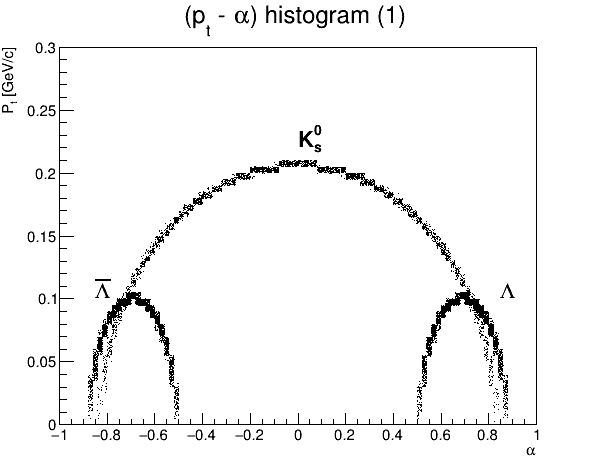

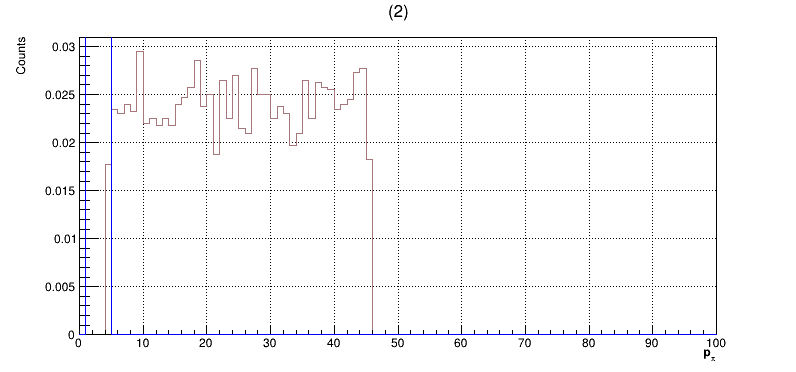

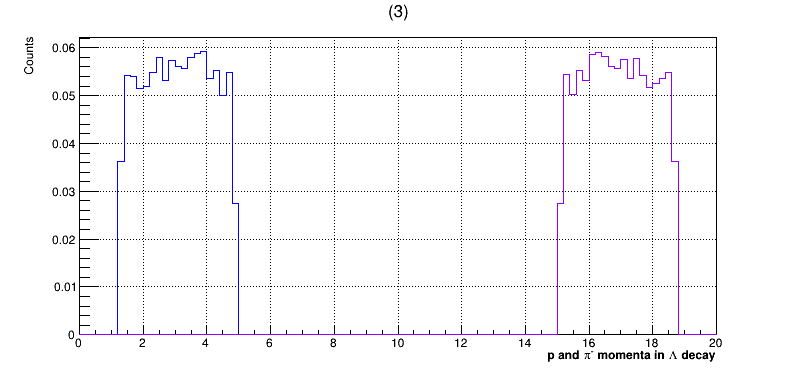

In [10]:
script();

### Результаты:
В программе моделируется кинематический распад нейтральной $V^0$-частицы ($K_S^0, \Lambda, \bar\Lambda$). Считаем заданными параметры лабораторной системы координат ($(p_x, p_y, p_z) = (0., 0., 50.)$), моделируем импульсы частиц, образовавшихся после распада, в системе центра масс и пересчитываем их в лабораторной системе координат с помощью преобразования Лоренца.  
  По этим данным необходимо восстановить сигнал распада исходной $V^0$ частицы. Вычисляются поперечная компонента импульса продуктов $p_t$ и безразмерный параметр $\alpha = \dfrac{p_L^- - p_L^+}{p_L^+ + p_L^-}$ - асимметрия продольных компонент заряженных частиц-продуктов распада. Каждому событию распада сопоставляется точка на плоскости $(\alpha - p_t)$, результат представляется в виде двумерной гистограммы. Распределение событий на этой плоскости будет разным для разных $V^0$ частиц, что и позволяет разделить события распада разных частиц.   
  * $K_s^0$ распадается на 2 частицы одинаковой массы, импульсы частиц распределены симметрично, что мы и видим на графике. Также можно заметить, что пересечение кривой $(p_t, \alpha)$ с осью $\alpha$ определяет отношение масс $m_{\pi}/m_{K_s^0} \approx 0.3$ (из уравнения эллипса)
  * Распад $\Lambda (\bar\Lambda)$ оказывается несимметричным из-за образующегося протона(антипротона), который является более тяжелой частицей по сравнению с пи-мезоном, поэтому эллипс этих частиц смещен на $\alpha = \pm 0.7$. На гистограмме (3) наблюдаем это обстоятельство - распределение протонов по импульсам лежат правее значений импульсов пи-мезона. 
  * $\textbf{(?)}$ На гистограмме (2) представлено распределение импульсов пионов ($\pi^{+}$ либо $\pi^{-}$) для распадов $K_S^0, \Lambda$ с целью увидеть что ширина распределения значений импульсов $\pi$ в реакции распада $K_S^0$ больше, чем в реакции распада $\Lambda$, что также осложняет восстановление сигнала распада $K_S^0$.
  * Существует область на графике (1), где события распада К-мезона и лямбда-гиперона пересекаются(параметры распада совпадают для разных частиц).  
  $\textbf{(?)}$ Есть предположение, что точка пересечения кривых должна определять некоторое пороговое значение $\alpha$, при котором мы можем разрешить события распада K и лябда частиц.